# Movielens
Analyzing movies 

### Load data

In [1]:
#http://www.grouplens.org/system/files/ml-1m.zip
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from io import StringIO 
movies = pd.read_csv('data/movies.dat', delimiter='::', names=['id', 'title', 'genre'])
ratings = pd.read_csv('data/ratings.dat', delimiter='::', names = ['user', 'item', 'rating', 'timestamp'])

In [2]:
movies.head()

,id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head()

,user,item,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [4]:
len(ratings)

1000209

In [5]:
ratings.describe()

,user,item,rating,timestamp
count,1000209.000000,1000209.000000,1000209.000000,1.000209e+06
mean,3024.512348,1865.539898,3.581564,9.722437e+08
std,1728.412695,1096.040689,1.117102,1.215256e+07
min,1.000000,1.000000,1.000000,9.567039e+08
25%,1506.000000,1030.000000,3.000000,9.653026e+08
50%,3070.000000,1835.000000,4.000000,9.730180e+08
75%,4476.000000,2770.000000,4.000000,9.752209e+08
max,6040.000000,3952.000000,5.000000,1.046455e+09


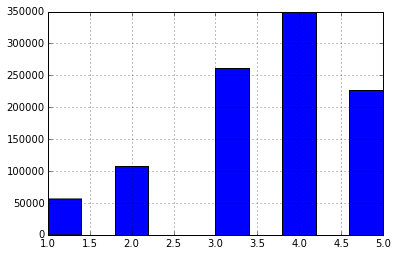

In [6]:
%matplotlib inline
ratings.rating.hist(bins=10);

## user - item matrix

In [7]:
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix

rows  = ratings['user']
cols  = ratings['item']
data = ratings['rating']

In [8]:
R=coo_matrix((data,(rows,cols)),shape=(max(rows)+1,max(cols)+1))
X=R.tocsr()

In [9]:
# reduce dimensionality
from sklearn.decomposition import TruncatedSVD
X = TruncatedSVD(n_components=100).fit_transform(X.T)

In [10]:
# nearest neighbors
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import *
N = 10
knn = NearestNeighbors(N, algorithm='brute', metric='euclidean', leaf_size=1000).fit(X)
distances, indices = knn.kneighbors(X,n_neighbors=N) 

dim = indices.shape
myidx = pd.Series(range(dim[0]*dim[1]))//dim[1]
df_dist = pd.DataFrame(dict(i1=myidx, i2=indices.flatten(), distance=distances.flatten()))
df_dist.head(10)

,distance,i1,i2
0,0.000000e+00,0,0
1,3.123149e-13,0,1195
2,3.123149e-13,0,3170
3,3.123149e-13,0,1229
4,3.123149e-13,0,1239
5,3.123149e-13,0,1182
6,3.123149e-13,0,1166
7,3.123149e-13,0,3023
8,3.123149e-13,0,1159
9,3.123149e-13,0,3080


In [12]:
df_merge = pd.DataFrame.merge(df_dist, movies, left_on='i1', right_on='id')
df_merge = pd.DataFrame.merge(df_merge, movies, left_on='i2', right_on='id')
df_merge.head(10)
#df_merge = df_merge.query("i1 != i2")
df = df_merge[['id_x', 'title_x', 'id_y', 'title_y', 'distance']]

## Results

In [13]:
movies[movies.title.str.contains("Star Wars")]

,id,title,genre
257,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi
1178,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War
1192,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War
2559,2628,Star Wars: Episode I - The Phantom Menace (1999),Action|Adventure|Fantasy|Sci-Fi


In [14]:
df[df.id_x == 260].sort("distance")

,id_x,title_x,id_y,title_y,distance
18013,260,Star Wars: Episode IV - A New Hope (1977),260,Star Wars: Episode IV - A New Hope (1977),0.000000
18017,260,Star Wars: Episode IV - A New Hope (1977),1196,Star Wars: Episode V - The Empire Strikes Back...,92.568117
18021,260,Star Wars: Episode IV - A New Hope (1977),1210,Star Wars: Episode VI - Return of the Jedi (1983),135.436718
18024,260,Star Wars: Episode IV - A New Hope (1977),1198,Raiders of the Lost Ark (1981),138.406618
18027,260,Star Wars: Episode IV - A New Hope (1977),1214,Alien (1979),145.372226
18032,260,Star Wars: Episode IV - A New Hope (1977),1240,"Terminator, The (1984)",147.297248
18042,260,Star Wars: Episode IV - A New Hope (1977),2628,Star Wars: Episode I - The Phantom Menace (1999),148.258867
18049,260,Star Wars: Episode IV - A New Hope (1977),2571,"Matrix, The (1999)",156.823379
18054,260,Star Wars: Episode IV - A New Hope (1977),1200,Aliens (1986),159.721513
18063,260,Star Wars: Episode IV - A New Hope (1977),1097,E.T. the Extra-Terrestrial (1982),160.957066
